## Pruning LeNet CNN on CIFAR-10

This Notebook gives a demo on how to prune the filters on a CNN on CIFAR-10

### Settings

In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *


# specify experiment settings
expName = 'cifar-lenet-v1_w1-500'   #change conv1 dim
w1 = 500 # change conv1 dim
w2 = 50

batchSize = 100
useGpu = True
numEpochs = 30
learningRate = 0.01
gamma = 0.1  # learning rate decay
lr_decay_step = 10 # decay lr every "x" epochs
momentum = 0.9
weight_decay = 5e-3

# -----------------------------------------------------------------------------


# experiment folder
expDir = os.path.join('./data', expName)

# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data(batchSize)

Files already downloaded and verified
Files already downloaded and verified


## Reduce Duplicate Filters

In [2]:
# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net

NetWide (
  (conv1): Conv2d(3, 500, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(500, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (1250 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [3]:
net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network data loss: 0.6778


In [4]:
# Settings
%matplotlib inline
from net_reduce import *

SIMIL_THRESH = 0.9
LAYER_CURR = 'conv2'
LAYER_NEXT = 'fc1'

### Network reduction

Reducing a network by eliminating near-duplicate filters consists of the following steps, after having formed groups of similar filters:

1. down-scale the filters of the current layer to have unit norm, and correspondingly up-scale the next layer filters.
2. collapse filter groups

In [5]:
# Check the network accuracy pre-reduction
net.eval()
net.cuda()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % orig_accu

net.cuda()
new_data_loss = get_dataset_loss(net, testloader)
orig_data_loss = np.asarray(orig_data_loss)
print 'Orig mean data loss: %f' % np.mean(orig_data_loss)

Network accuracy: 76.00%
Orig mean data loss: 0.677848


### Reduce similar filters


In [6]:
# 1. unit-normalizes current layer filters
# 2. finds similar groups of filters and merges them

# code: net_reduce.py
#   return args are for diagnostics and n_comps needed for norm-baseline
n_comps, cc_list, similMat, adj_mat = \
reduce_similar_filters(net, LAYER_CURR, LAYER_NEXT, SIMIL_THRESH)

IndexError: list index out of range

In [8]:
# Sanity check: verify that the network's param sizes have changed
print net.conv1.weight.size()
print net.conv1.bias.size()
print net.conv2.weight.size()

torch.Size([425, 3, 5, 5])
torch.Size([425])
torch.Size([50, 425, 5, 5])


In [9]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

res = {'orig_accu': orig_accu, 'reduced_accu': abl_accu, \
       'num_filters': n_comps}
with open(os.path.join(expDir,'reduce_dup_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
    json.dump(res, res_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

Reduced network accuracy: 76.00 %


In [10]:
# save reduced network 
torch.save(net.state_dict(), os.path.join(expDir,'net-reduced-dup-%.2f.dat' % SIMIL_THRESH))

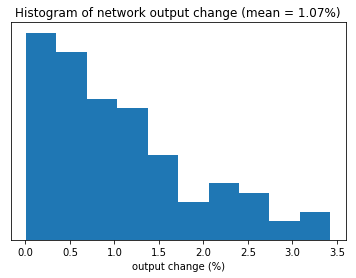

In [11]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
f.savefig(os.path.join(expDir,'loss-delta-reduced-dup-%.2f.png' % SIMIL_THRESH))

### Baseline: low L1 norm

In [13]:
# baseline: keep same number of filters as the duplicate method
NUM_KEEP = n_comps 

# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)


Original network data loss: 0.6778


In [14]:
# code: net_reduce.py
reduce_low_norm_filters(net, LAYER_CURR, LAYER_NEXT, NUM_KEEP)

In [15]:
# Evaluate baseline network's accuracy
net.cuda()
net.eval()
baseline_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % baseline_accu

res = {'orig_accu': orig_accu, 'reduced_accu': baseline_accu, \
        'num_filters': n_comps}
with open(os.path.join(expDir,'reduce_norm_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
    json.dump(res, res_file, indent=4, separators=(',', ': '), \
                                          sort_keys=True)

Reduced network accuracy: 76.00 %


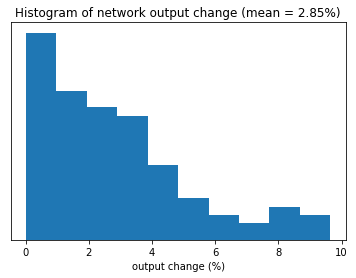

In [16]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
f.savefig(os.path.join(expDir,'loss-delta-reduced-norm-%.2f.png' % SIMIL_THRESH))